# Project Akhir Zenius Data Analytics - Home Credit Default Risk

## Data Preparation

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import featuretools as ft
import warnings
warnings.filterwarnings('ignore')

Mempersiapkan dataset untuk proses automated feature engineering dan joining. Dataset akan dibatasi 10000 rows terlebih dahulu untuk memaksimalkan performa perhitungan.

In [ ]:
app = pd.read_csv('application_train.csv').sort_values('SK_ID_CURR').reset_index(drop = True)
nrows=app.shape[0]

bureau = pd.read_csv('bureau.csv', nrows=nrows).sort_values(['SK_ID_CURR', 'SK_ID_BUREAU']).reset_index(drop = True)
bureau_balance = pd.read_csv('bureau_balance.csv', nrows=nrows).sort_values('SK_ID_BUREAU').reset_index(drop = True)
cash = pd.read_csv('POS_CASH_balance.csv', nrows=nrows).sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True)
credit = pd.read_csv('credit_card_balance.csv', nrows=nrows).sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True)
previous = pd.read_csv('previous_application.csv', nrows=nrows).sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True)
installments = pd.read_csv('installments_payments.csv', nrows=nrows).sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True)

### Menggabungkan Data dan Feature Engineering

Feature engineering atau rekayasa fitur merupakan proses pemilihan, manipulasi, dan transformasi data mentah menjadi fitur baru yang dapat digunakan dalam model supervised machine learning. Agar machine learning bekerja dengan baik pada tugas-tugas baru, mungkin perlu merancang dan melatih fitur yang lebih baik. Rekayasa fitur, secara sederhana, adalah tindakan mengubah data mentah menjadi fitur yang diinginkan menggunakan pendekatan statistik atau machine learning.

Pada proyek ini, akan dilakukan pembuatan fitur baru secara otomatis menggunakan library FeatureTools.

#### Pembuatan Entities

Sebelum menggunakan FeatureTools, kita harus membuat suatu Entity yang merupakan sebuah Pandas DataFrame kosong. Entity ini akan berisi index unik seperti yang terdapat pada tabel app, bureau, dan previous ('SK_ID_CURR', SK_ID_BUREAU', dan 'SK_ID_PREV'). Untuk dataset lainnya yang tidak mempunyai index unik, kita akan membuat index secara manual dengan menambahkan parameter make_index = True lalu kemudian index tersebut diberi nama.

In [ ]:
#Pertama, akan dibuat entity kosong berupa Pandas DataFrame
es = ft.EntitySet(id = 'clients')

In [ ]:
# Selanjutnya, akan dibuat entity pada tiap dataset

# Entity yang mempunyai index unik
es = es.add_dataframe(dataframe_name="app", dataframe=app, index="SK_ID_CURR")

es = es.add_dataframe(dataframe_name="bureau",
                      dataframe=bureau, index="SK_ID_BUREAU")

es = es.add_dataframe(dataframe_name="previous",
                      dataframe=previous, index="SK_ID_PREV")

# Entity yang tidak mempunyai index unik
es = es.add_dataframe(dataframe_name="bureau_balance", dataframe=bureau_balance,
                      make_index=True, index="bureaubalance_index")

es = es.add_dataframe(dataframe_name="cash", dataframe=cash,
                      make_index=True, index="cash_index")

es = es.add_dataframe(dataframe_name="installments", dataframe=installments,
                      make_index=True, index="installments_index")

es = es.add_dataframe(dataframe_name="credit", dataframe=credit,
                      make_index=True, index="credit_index")

#### Penentuan Relationship

Selanjutnya, akan dilakukan penentuan relationship tiap dataset. Relationship tiap dataset dapat dilihat pada gambar di bawah.

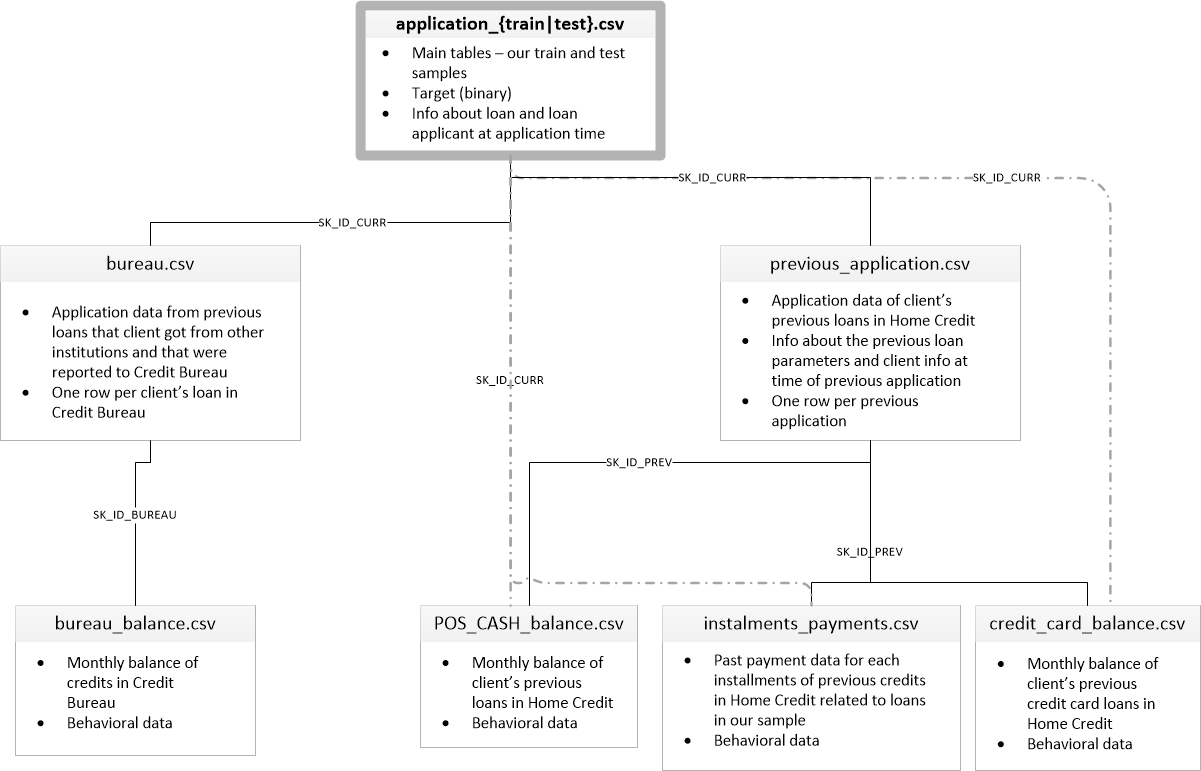

In [ ]:
#Hubungan antara dataset app dan bureau: bureau.SK_ID_CURR -> app.SK_ID_CURR
r_app_bureau = ft.Relationship(es, "app", "SK_ID_CURR", "bureau", "SK_ID_CURR")

#Hubungan antara dataset bureau dengan bureau balance: bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
r_bureau_balance = ft.Relationship(es, "bureau", "SK_ID_BUREAU", "bureau_balance",
                                   "SK_ID_BUREAU")

#Hubungan antara dataset app dengan previous: previous.SK_ID_CURR -> app.SK_ID_CURR
r_app_previous = ft.Relationship(es, "app", "SK_ID_CURR", "previous", "SK_ID_CURR")

#Hubungan antara dataset previous dengan cash: cash.SK_ID_PREV -> previous.SK_ID_PREV
r_previous_cash = ft.Relationship(es, "previous", "SK_ID_PREV", "cash", "SK_ID_PREV")

#Hubungan antara dataset previous dengan installments: installments.SK_ID_PREV -> previous.SK_ID_PREV
r_previous_installments = ft.Relationship(es, "previous", "SK_ID_PREV", "installments",
                                          "SK_ID_PREV")

#Hubungan antara dataset previous dengan credit: credit.SK_ID_PREV -> previous.SK_ID_PREV
r_previous_credit = ft.Relationship(es, "previous", "SK_ID_PREV", "credit",
                                    "SK_ID_PREV")

In [ ]:
#Menambahkan hubungan antar dataset pada set entities
es = es.add_relationships([r_app_bureau, r_bureau_balance, r_app_previous,
                           r_previous_cash, r_previous_installments, r_previous_credit])
# Melihat set entities dan hubungannya
es

Entityset: clients
  DataFrames:
    app [Rows: 307511, Columns: 122]
    bureau [Rows: 307511, Columns: 17]
    previous [Rows: 307511, Columns: 37]
    bureau_balance [Rows: 307511, Columns: 4]
    cash [Rows: 307511, Columns: 9]
    installments [Rows: 307511, Columns: 9]
    credit [Rows: 307511, Columns: 24]
  Relationships:
    bureau.SK_ID_CURR -> app.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    previous.SK_ID_CURR -> app.SK_ID_CURR
    cash.SK_ID_PREV -> previous.SK_ID_PREV
    installments.SK_ID_PREV -> previous.SK_ID_PREV
    credit.SK_ID_PREV -> previous.SK_ID_PREV

#### Deep Feature Synthesis

Deep Feature Synthesis (DFS) merupakan suatu proses pada library FeatureTools untuk membuat fitur baru. Sebelum melakukan Deep Feature Synthesis, kita perlu menentukan fitur primitif.

Fitur primitif merupakan suatu operasi yang akan diterapkan pada tabel yang akan digabungkan untuk membuat sebuah fitur otomatis. Pada proyek ini, fitur primitif yang akan digunakan adalah fitur agregat berupa: sum, count, min, max, mean, mode.

Fungsi DFS akan menerima input berupa entityset, target_dataframe_name (dataset yang akan digunakan untuk membuat fitur), agg_primitives (fitur primitif agregat yang akan digunakan), dan max_depth. Max depth merupakan berapa banyak operasi fitur primitif yang akan diaplikasikan kepada suatu fitur baru. Contohnya, max_depth = 1 adalah MAX(previous.loan_amount), max_depth = 2 adalah MAX(previous(MEAN(installments.payment))).

Kita juga harus menginput features_only = False agar fungsi DFS menghitung seluruh fitur di dalam datasetnya.

In [ ]:
# Pembuatan fitur baru dengan DFS
feature_matrix, feature_names = ft.dfs(entityset = es, target_dataframe_name = 'app',
                                                 agg_primitives = ['sum', 'count', 'min', 'max', 'mean', 'mode'],
                                                 max_depth = 2, features_only = False, verbose = True)

feature_matrix.head(10)

Built 1190 features
Elapsed: 18:11 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,SUM(credit.previous.DAYS_FIRST_DUE),SUM(credit.previous.DAYS_LAST_DUE),SUM(credit.previous.DAYS_LAST_DUE_1ST_VERSION),SUM(credit.previous.DAYS_TERMINATION),SUM(credit.previous.HOUR_APPR_PROCESS_START),SUM(credit.previous.NFLAG_INSURED_ON_APPROVAL),SUM(credit.previous.RATE_DOWN_PAYMENT),SUM(credit.previous.RATE_INTEREST_PRIMARY),SUM(credit.previous.RATE_INTEREST_PRIVILEGED),SUM(credit.previous.SELLERPLACE_AREA)
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,True,Cash loans,M,False,True,0,202500.0,406597.5,24700.5,351000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100003,False,Cash loans,F,False,False,0,270000.0,1293502.5,35698.5,1129500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100004,False,Revolving loans,M,True,True,0,67500.0,135000.0,6750.0,135000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100006,False,Cash loans,F,False,True,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100007,False,Cash loans,M,False,True,0,121500.0,513000.0,21865.5,513000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100008,False,Cash loans,M,False,True,0,99000.0,490495.5,27517.5,454500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100009,False,Cash loans,F,True,True,1,171000.0,1560726.0,41301.0,1395000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100010,False,Cash loans,M,True,True,0,360000.0,1530000.0,42075.0,1530000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100011,False,Cash loans,F,False,True,0,112500.0,1019610.0,33826.5,913500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Menyimpan dataframe yang sudah dilakukan rekayasa fitur dan penggabungan menjadi format csv

feature_matrix.to_csv('joined_data.csv')

### Data Preprocessing

Sebelum dilakukan data preprocessing, dilakukan pendefinisian fungsi untuk mengurangi penggunaan memori. Fungsi ini berisi reformating tipe data agar penggunaan memori menjadi lebih ringan.

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [ ]:
print('-' * 80)
print('Joined Data')
df = import_data('joined_data.csv')

--------------------------------------------------------------------------------
Joined Data


C:\Users\User\AppData\Local\Temp\ipykernel_20808\147790395.py:42: DtypeWarning: Columns (178,422,462,463,464,1071,1072,1073,1074,1075,1076,1077,1078,1079,1080,1081,1082,1083,1084,1085,1169) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, parse_dates=True, keep_date_col=True)


Memory usage of dataframe is 2724.44 MB
Memory usage after optimization is: 975.43 MB
Decreased by 64.2%


In [ ]:
print('Dataset shape:', df.shape[0], 'baris dan', df.shape[1], 'kolom.')

Dataset shape: 307511 baris dan 1191 kolom.


Menurut beberapa Notebook pada Kaggle, terdapat outliers pada kolom-kolom terkait 'DAYS', yaitu 365243. Maka dari itu, kita akan mengubah outliers ini menjadi missing value.

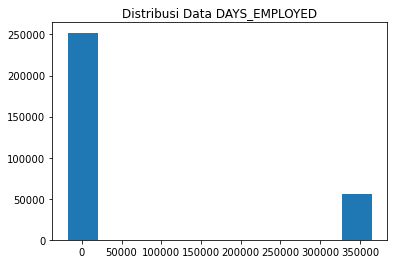

In [ ]:
#Melihat distribusi data DAYS_EMPLOYED

plt.hist(x=df['DAYS_EMPLOYED'])
plt.title('Distribusi Data DAYS_EMPLOYED')

plt.show()

In [ ]:
def replace_day_outliers(df):
    """Mengubah 365243 dengan np.nan pada setiap kolom dengan nama DAYS"""
    for col in df.columns:
        if "DAYS" in col:
            df[col] = df[col].replace({365243: np.nan})

    return df

In [ ]:
replace_day_outliers(df)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,SUM(credit.previous.DAYS_FIRST_DUE),SUM(credit.previous.DAYS_LAST_DUE),SUM(credit.previous.DAYS_LAST_DUE_1ST_VERSION),SUM(credit.previous.DAYS_TERMINATION),SUM(credit.previous.HOUR_APPR_PROCESS_START),SUM(credit.previous.NFLAG_INSURED_ON_APPROVAL),SUM(credit.previous.RATE_DOWN_PAYMENT),SUM(credit.previous.RATE_INTEREST_PRIMARY),SUM(credit.previous.RATE_INTEREST_PRIVILEGED),SUM(credit.previous.SELLERPLACE_AREA)
0,100002,1.0,Cash loans,M,0.0,1.0,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0.0,Cash loans,F,0.0,0.0,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0.0,Revolving loans,M,1.0,1.0,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0.0,Cash loans,F,0.0,1.0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0.0,Cash loans,M,0.0,1.0,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0.0,Cash loans,M,0.0,0.0,0,157500.0,254700.0,27558.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307507,456252,0.0,Cash loans,F,0.0,1.0,0,72000.0,269550.0,12001.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307508,456253,0.0,Cash loans,F,0.0,1.0,0,153000.0,677664.0,29979.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307509,456254,1.0,Cash loans,F,0.0,1.0,0,171000.0,370107.0,20205.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


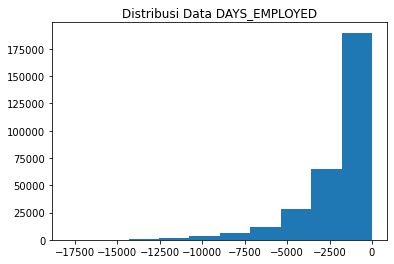

In [ ]:
#Pengecekan ulang

plt.hist(x=df['DAYS_EMPLOYED'])
plt.title('Distribusi Data DAYS_EMPLOYED')

plt.show()

Setelah anomali data dihilangkan, kolom DAYS_EMPLOYED terdistribusi secara left-skewed atau negative-skewed

Melakukan pengecekan data duplicate.

In [ ]:
duplicate = df.duplicated()

duplicate.value_counts()

False    307511
dtype: int64

Hasil menunjukkan nilai False yang berarti bahwa tidak ada data duplikat pada dataset.

#### Missing Value Checking

In [ ]:
#Filling factor pada dataset

missing_data = df.isnull().sum(axis=0).reset_index()
missing_data.columns = ['variable', 'missing values']
missing_data['filling factor(%)']=(df.shape[0]-missing_data['missing values'])/df.shape[0]*100
missing_data = missing_data.sort_values('filling factor(%)').reset_index(drop=True)
missing_data

,variable,missing values,filling factor(%)
0,MIN(credit.previous.RATE_INTEREST_PRIMARY),307511,0.0
1,MAX(credit.previous.RATE_INTEREST_PRIMARY),307511,0.0
2,MIN(credit.previous.RATE_INTEREST_PRIVILEGED),307511,0.0
3,MAX(credit.previous.RATE_INTEREST_PRIVILEGED),307511,0.0
4,MEAN(credit.previous.RATE_INTEREST_PRIVILEGED),307511,0.0
...,...,...,...
1186,SUM(previous.MAX(credit.AMT_RECIVABLE)),0,100.0
1187,SUM(previous.MAX(credit.AMT_RECEIVABLE_PRINCIP...,0,100.0
1188,SUM(previous.MAX(credit.AMT_PAYMENT_TOTAL_CURR...,0,100.0
1189,SUM(previous.MAX(credit.SK_ID_CURR)),0,100.0


Terdapat banyak sekali missing values, untuk memastikannya, kita akan membuat pola distribusi missing values.

Text(0.5, 1.0, 'Filling Factor (%) Dataset')

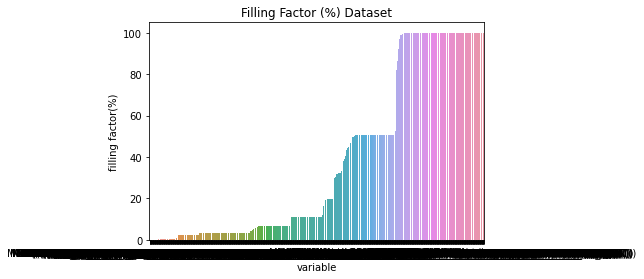

In [ ]:
#Visualisasi filling factor

sns.barplot(data=missing_data, x='variable', y='filling factor(%)')
plt.title('Filling Factor (%) Dataset')

Kita akan melakukan drop kolom pada kolom yang mempunyai filling factor kurang dari atau sama dengan 30%

In [ ]:
drop_column = missing_data[missing_data['filling factor(%)']<=30]['variable']
print('Jumlah kolom yang mempunyai missing value diatas 70%:',drop_column.shape[0])

Jumlah kolom yang mempunyai missing value diatas 70%: 658


In [ ]:
#Drop kolom

df.drop(columns=drop_column, inplace=True)

In [ ]:
#Filling factor pada dataset

missing_data = df.isnull().sum(axis=0).reset_index()
missing_data.columns = ['variable', 'missing values']
missing_data['filling factor(%)']=(df.shape[0]-missing_data['missing values'])/df.shape[0]*100
missing_data = missing_data.sort_values('filling factor(%)').reset_index(drop=True)
missing_data

,variable,missing values,filling factor(%)
0,COMMONAREA_AVG,214865,30.127703
1,COMMONAREA_MODE,214865,30.127703
2,COMMONAREA_MEDI,214865,30.127703
3,NONLIVINGAPARTMENTS_AVG,213514,30.567037
4,NONLIVINGAPARTMENTS_MEDI,213514,30.567037
...,...,...,...
528,SUM(installments.DAYS_INSTALMENT),0,100.000000
529,SUM(installments.DAYS_ENTRY_PAYMENT),0,100.000000
530,SUM(installments.AMT_PAYMENT),0,100.000000
531,SUM(credit.AMT_RECEIVABLE_PRINCIPAL),0,100.000000


Untuk mengatasi missing values yang tersisa, kita akan menggunakan SimpleImputer dari Library sklearn. Namun sebelum itu, akan dilakukan encoding terlebih dahulu untuk mengatasi kolom kategori dan mengubahnya menjadi kolom numerikal.

In [ ]:
categorical_list = []
numerical_list = []

for i in df.columns.tolist():
    if df[i].dtype=='category':
        categorical_list.append(i)
    else:
        numerical_list.append(i)

print('Banyaknya fitur kategorikal pada dataset:', str(len(categorical_list)))
print('Banyaknya fitur numerikal pada dataset:', str(len(numerical_list)))

Banyaknya fitur kategorikal pada dataset: 29
Banyaknya fitur numerikal pada dataset: 504


#### One-Hot-Encoding vs Label-Encoding

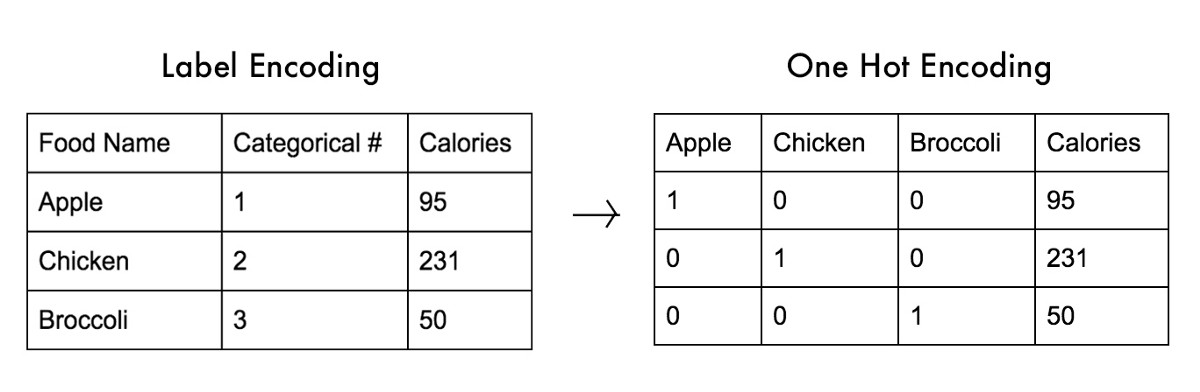

Terdapat dua jenis encoding yang umum digunakan dalam analisis data, yaitu One-Hot-Encoding dan Label-Encoding. Label encoding tidak menambah jumlah kolom dan hanya mengubah atau menetapkan tiap nilai yang ada pada kolom kategori menjadi sebuah integer. Sedangkan one hot encoding akan membuat kolom baru untuk setiap nilai unik yang ada pada suatu kolom kategori. Setiap pengamatan menerima nilai 1 untuk kolom yang sesuai dan 0 di semua kolom baru lainnya.

Pada projek ini, kita akan melakukan label encoding agar memudahkan dalam melakukan feature selection untuk dipakai pada analisis deskriptif dan diagnostik. Selain itu, penggunaan label encoding pada proyek ini juga bertujuan untuk meringankan beban memori pada komputer.

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le_count = 0

# Melakukan iterasi untuk semua kolom
for col in feature_matrix.columns:
    if df[col].dtype == 'category':
        # Melatih library LabelEncoder untuk dataset df
        le.fit(df[col])
        # Transformasi data pada dataset
        df[col] = le.transform(df[col])

        # Melacak jumlah kolom yang dilakukan label encoding
        le_count += 1

print('%d kolom telah dilakukan label encoding.' % le_count)

29 kolom telah dilakukan label encoding.


Setelah melakukan encoding, maka setiap kolom kategori sudah diubah menjadi kolom numerikal. Maka dari itu, dataset sudah siap untuk dilakukan Imputer atau pengisian missing value. Metode pengisian missing value akan menggunakan metode 'median'.

In [ ]:
# Menyimpan nama kolom
columns = df.columns

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = 'median')


# Melatih imputer dengan fungsi fit pada dataset df
imputer.fit(df)

# Transformasi dataset df
df = imputer.transform(df)

In [ ]:
# Membuat ulang dataframe
df = pd.DataFrame(df, columns=columns)

Pengecekan ulang missing value pada train dan test dataset

In [ ]:
#Filling factor pada dataset df

missing_data = df.isnull().sum(axis=0).reset_index()
missing_data.columns = ['variable', 'missing values']
missing_data['filling factor(%)']=(df.shape[0]-missing_data['missing values'])/df.shape[0]*100
missing_data = missing_data.sort_values('filling factor(%)').reset_index(drop=True)
missing_data

,variable,missing values,filling factor(%)
0,SK_ID_CURR,0,100.0
1,MIN(previous.SUM(credit.CNT_DRAWINGS_OTHER_CUR...,0,100.0
2,MIN(previous.SUM(credit.CNT_DRAWINGS_CURRENT)),0,100.0
3,MIN(previous.SUM(credit.CNT_DRAWINGS_ATM_CURRE...,0,100.0
4,MIN(previous.SUM(credit.AMT_TOTAL_RECEIVABLE)),0,100.0
...,...,...,...
528,MIN(previous.AMT_DOWN_PAYMENT),0,100.0
529,MIN(previous.AMT_CREDIT),0,100.0
530,MIN(previous.AMT_APPLICATION),0,100.0
531,MODE(previous.CHANNEL_TYPE),0,100.0


Text(0.5, 1.0, 'Filling Factor (%) Dataset')

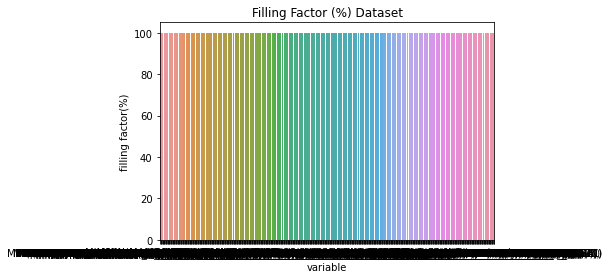

In [ ]:
#Visualisasi filling factor

sns.barplot(data=missing_data, x='variable', y='filling factor(%)')
plt.title('Filling Factor (%) Dataset')

Semua kolom sudah terisi dan tidak ada lagi missing values, dengan ini dataset sudah siap untuk pemodelan.

#### Manual Feature Engineering

Pada manual feature engineering, kita akan membuat kolom:
* **AGE:** Merupakan kolom yang berisi nilai absolut dari kolom 'DAYS_BIRTH' dan kemudian dibagi 365
* **DAYS_EMPLOYED_AGE_PERCENT:** Merupakan kolom yang berisi perbandingan antara 'DAYS_EMPLOYED' dengan 'DAYS_BIRTH'. Kolom ini juga menunjukkan persentase lama bekerja dibandingkan umur klien.

In [ ]:
#Age
df['AGE']=abs(df['DAYS_BIRTH']/365)

#Days Employed per Age
df['DAYS_EMPLOYED_AGE_PERCENT']=df['DAYS_EMPLOYED']/df['DAYS_BIRTH']

#### Feature Selection

Dalam melakukan feature selection, kita memakai cohen effect size yang mengeluarkan output berupa d atau besar efek suatu fitur terhadap target.

In [ ]:
def cohen_effect_size(X, y):
    """Calculates the Cohen effect size of each feature.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vector, where n_samples in the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target vector relative to X
        Returns
        -------
        cohen_effect_size : array, shape = [n_features,]
            The set of Cohen effect values.
    """
    group1, group2 = X[y==0], X[y==1]
    diff = group1.mean() - group2.mean()
    var1, var2 = group1.var(), group2.var()
    n1, n2 = group1.shape[0], group2.shape[0]
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    d = diff / np.sqrt(pooled_var)
    return abs(d)

In [ ]:
#Menyimpan kolom target pada variabel y dan kemudian menghapusnya dari dataset df

y = df['TARGET']
del df['TARGET']

In [ ]:
columns=df.columns #List nama kolom pada dataset

print('Number of features %d' % len(columns))
effect_sizes = cohen_effect_size(df[columns], y)

Number of features 534


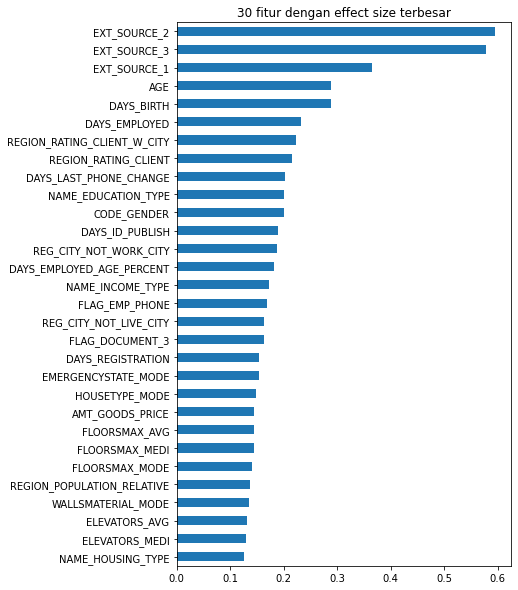

In [ ]:
effect_sizes.reindex(effect_sizes.abs().sort_values(ascending=False).nlargest(30).index)[::-1].plot.barh(figsize=(6, 10));
plt.title('30 fitur dengan effect size terbesar');

In [ ]:
significant_features = [f for f in columns if effect_sizes.loc[f] > 0.1]
print('Fitur signifikan %d: %s' % (len(significant_features), significant_features))

Fitur signifikan 46: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'ELEVATORS_AVG', 'FLOORSMAX_AVG', 'LIVINGAREA_AVG', 'ELEVATORS_MODE', 'FLOORSMAX_MODE', 'LIVINGAREA_MODE', 'ELEVATORS_MEDI', 'FLOORSMAX_MEDI', 'LIVINGAREA_MEDI', 'HOUSETYPE_MODE', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_6', 'MEAN(previous.DAYS_DECISION)', 'MIN(previous.DAYS_DECISION)', 'MODE(previous.CODE_REJECT_REASON)', 'AGE', 'DAYS_EMPLOYED_AGE_PERCENT']


Tidak semua hasil feature engineering masuk pada fitur yang signifikan, hanya kolom AGE dan DAYS_EMPLOYED_AGE_PERCENT saja yang termasuk signifikan terhadap perubahan TARGET.

In [ ]:
df = df[significant_features]
df.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,AMT_CREDIT,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,MEAN(previous.DAYS_DECISION),MIN(previous.DAYS_DECISION),MODE(previous.CODE_REJECT_REASON),AGE,DAYS_EMPLOYED_AGE_PERCENT
0,0.0,1.0,406597.5,351000.0,7.0,4.0,1.0,0.018799,-9461.0,-637.0,...,2.0,2.0,-1134.0,1.0,0.0,-694.0,-828.0,9.0,25.920548,0.067329
1,0.0,0.0,1293502.5,1129500.0,4.0,1.0,1.0,0.003542,-16765.0,-1188.0,...,0.0,0.0,-828.0,1.0,0.0,-694.0,-828.0,9.0,45.931507,0.070862
2,1.0,1.0,135000.0,135000.0,7.0,4.0,1.0,0.010033,-19046.0,-225.0,...,0.0,0.0,-815.0,0.0,0.0,-694.0,-828.0,9.0,52.180822,0.011814
3,0.0,0.0,312682.5,297000.0,7.0,4.0,1.0,0.008018,-19005.0,-3039.0,...,0.0,0.0,-617.0,1.0,0.0,-181.0,-181.0,7.0,52.068493,0.159905
4,0.0,1.0,513000.0,513000.0,7.0,4.0,1.0,0.028656,-19932.0,-3038.0,...,0.0,0.0,-1106.0,0.0,0.0,-866.0,-867.0,7.0,54.608219,0.152418


In [ ]:
df.to_csv('data_model_clean.csv')

Dapat dilihat bahwa semua fitur yang dihasilkan dari hasil manual feature engineering tergolong ke dalam fitur yang signifikan, yaitu **AGE** dan **DAYS_EMPLOYED_AGE_PERCENT**. Terdapat juga 3 fitur yang dihasilkan dari automatic feature engineering, yaitu **MEAN(previous.DAYS_DECISION)**, **MIN(previous.DAYS_DECISION)**, dan **MODE(previous.CODE_REJECT_REASON)**

### Membuat dataframe baru dengan fitur yang telah dipilih untuk keperluan deskriptif dan diagnostik analisis

Pembuatan dataframe baru diperlukan karena dataframe sebelumnya (train) sudah mengalami encoding sehingga value kolom kategori yang asli sudah diubah menjadi nilai numerik. Sehingga pada tahap ini, akan ada 2 datafram:
* **df:** akan digunakan sebagai dataset modeling supervised machine learning classification dan analisis korelasi
* **df2:** akan digunakan untuk keperluan analisis deskriptif dan diagnostik.

Pembagian dua dataset ini diperlukan karena semua tipe data pada df sudah berupa numerikal yang sudah melalui encoding, sedangkan untuk analisis deskriptif dan diagnostik beserta pembuatan grafiknya, akan lebih baik jika menggunakan tipe data seperti awalnya, yaitu tipe data numerik dan kategorikal.

In [ ]:
print('-' * 80)
print('Joined Data')
df2 = import_data('joined_data.csv')

--------------------------------------------------------------------------------
Joined Data
Memory usage of dataframe is 2724.44 MB
Memory usage after optimization is: 975.43 MB
Decreased by 64.2%


In [ ]:
replace_day_outliers(df2)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,SUM(credit.previous.DAYS_FIRST_DUE),SUM(credit.previous.DAYS_LAST_DUE),SUM(credit.previous.DAYS_LAST_DUE_1ST_VERSION),SUM(credit.previous.DAYS_TERMINATION),SUM(credit.previous.HOUR_APPR_PROCESS_START),SUM(credit.previous.NFLAG_INSURED_ON_APPROVAL),SUM(credit.previous.RATE_DOWN_PAYMENT),SUM(credit.previous.RATE_INTEREST_PRIMARY),SUM(credit.previous.RATE_INTEREST_PRIVILEGED),SUM(credit.previous.SELLERPLACE_AREA)
0,100002,1.0,Cash loans,M,0.0,1.0,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0.0,Cash loans,F,0.0,0.0,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0.0,Revolving loans,M,1.0,1.0,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0.0,Cash loans,F,0.0,1.0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0.0,Cash loans,M,0.0,1.0,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0.0,Cash loans,M,0.0,0.0,0,157500.0,254700.0,27558.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307507,456252,0.0,Cash loans,F,0.0,1.0,0,72000.0,269550.0,12001.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307508,456253,0.0,Cash loans,F,0.0,1.0,0,153000.0,677664.0,29979.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307509,456254,1.0,Cash loans,F,0.0,1.0,0,171000.0,370107.0,20205.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


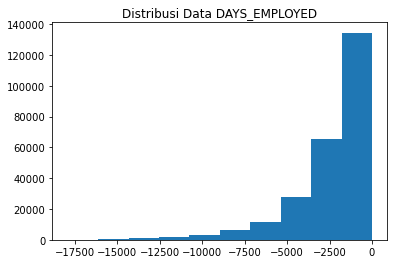

In [ ]:
#Pengecekan ulang

plt.hist(x=df2['DAYS_EMPLOYED'])
plt.title('Distribusi Data DAYS_EMPLOYED')

plt.show()

In [ ]:
#Menghapus sementara nama kolom AGE dan DAYS_EMPLOYED_AGE_PERCENT
significant_features.remove('AGE')
significant_features.remove('DAYS_EMPLOYED_AGE_PERCENT')
#Menambahkan kolom TARGET
significant_features.append('TARGET')

df2 = df2[significant_features] #Hanya menggunakan fitur yang signifikan

In [ ]:
#Filling factor pada train dataset

missing_data = df2.isnull().sum(axis=0).reset_index()
missing_data.columns = ['variable', 'missing values']
missing_data['filling factor(%)']=(df2.shape[0]-missing_data['missing values'])/df2.shape[0]*100
missing_data = missing_data.sort_values('filling factor(%)').reset_index(drop=True)
missing_data

,variable,missing values,filling factor(%)
0,EXT_SOURCE_1,173378,43.618927
1,ELEVATORS_AVG,163891,46.704020
2,ELEVATORS_MODE,163891,46.704020
3,ELEVATORS_MEDI,163891,46.704020
4,WALLSMATERIAL_MODE,156341,49.159217
5,LIVINGAREA_AVG,154350,49.806674
6,LIVINGAREA_MODE,154350,49.806674
7,LIVINGAREA_MEDI,154350,49.806674
8,HOUSETYPE_MODE,154297,49.823909
9,FLOORSMAX_MODE,153020,50.239178


In [ ]:
categorical_list = []
numerical_list = []
for i in df2.columns.tolist():
    if df2[i].dtype=='category':
        categorical_list.append(i)
    else:
        numerical_list.append(i)
print('Number of categorical features:', str(len(categorical_list)))
print('Number of numerical features:', str(len(numerical_list)))

Number of categorical features: 10
Number of numerical features: 35


In [ ]:
from sklearn.impute import SimpleImputer
df2[numerical_list] = SimpleImputer(strategy='median').fit_transform(df2[numerical_list])

df2[categorical_list] = SimpleImputer(strategy='most_frequent').fit_transform(df2[categorical_list])

In [ ]:
#Filling factor pada train dataset

missing_data = df2.isnull().sum(axis=0).reset_index()
missing_data.columns = ['variable', 'missing values']
missing_data['filling factor(%)']=(df2.shape[0]-missing_data['missing values'])/df2.shape[0]*100
missing_data = missing_data.sort_values('filling factor(%)').reset_index(drop=True)
missing_data

,variable,missing values,filling factor(%)
0,NAME_CONTRACT_TYPE,0,100.0
1,FLOORSMAX_AVG,0,100.0
2,LIVINGAREA_AVG,0,100.0
3,ELEVATORS_MODE,0,100.0
4,FLOORSMAX_MODE,0,100.0
5,LIVINGAREA_MODE,0,100.0
6,ELEVATORS_MEDI,0,100.0
7,FLOORSMAX_MEDI,0,100.0
8,LIVINGAREA_MEDI,0,100.0
9,HOUSETYPE_MODE,0,100.0


In [ ]:
#Age
df2['AGE']=abs(df2['DAYS_BIRTH']/365)

#Days Employed per Age
df2['DAYS_EMPLOYED_AGE_PERCENT']=df2['DAYS_EMPLOYED']/df2['DAYS_BIRTH']

In [ ]:
df2.to_csv('application_clean.csv')

## Modeling

In [ ]:
print('-' * 80)
print('Modeling Data')
df = import_data('data_model_clean.csv')

print('-' * 80)
print('Deskriptif Data')
df2 = import_data('application_clean.csv')

--------------------------------------------------------------------------------
Modeling Data
Memory usage of dataframe is 110.27 MB
Memory usage after optimization is: 29.33 MB
Decreased by 73.4%
--------------------------------------------------------------------------------
Deskriptif Data
Memory usage of dataframe is 110.56 MB
Memory usage after optimization is: 27.28 MB
Decreased by 75.3%


In [ ]:
y = df2['TARGET']

In [ ]:
#Train Test Split, untuk memisah dataset menjadi data training dan data test

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.3, random_state = 42)

In [ ]:
#Normalisasi data

from sklearn.preprocessing import MinMaxScaler

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Repeat with the scaler
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
scaler = MinMaxScaler(feature_range = (0, 1))

scaler.fit(df)

df = scaler.transform(df)

### Supervised Machine Learning Classification dengan Logistik Regresi, Random Forest, dan XGBoost.

#### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Membuat model
log_reg = LogisticRegression(C = 0.0001)

# Melatih model
log_reg.fit(X_train, y_train)

LogisticRegression(C=0.0001)

**EVALUASI KEMAMPUAN MODEL**

Sebelum menentukan matriks evaluasi yang paling baik, kita akan melakukan visualisasi kolom TARGET untuk mengetahui perbandingan antara TARGET 0 dan 1. Hal ini bertujuan untuk melihat apakah data tersebut imbalance atau tidak.

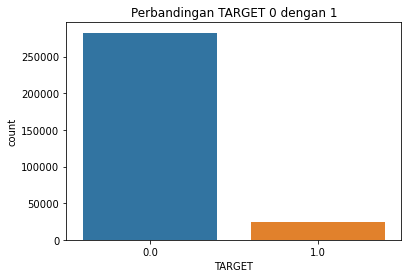

In [ ]:
sns.countplot(data=df2, x='TARGET')
plt.title('Perbandingan TARGET 0 dengan 1')
plt.show()

Dikarenakan kolom TARGET mempunyai perbandingan value yang tidak seimbang, maka matriks akurasi kurang cocok untuk digunakan. Pada kasus ini, matriks yang paling cocok adalah matriks ROC AUC SCORE. Hal ini karena kurva ROC tidak peka terhadap ketidakseimbangan data dan kurva ROC adalah metode yang paling umum untuk memvisualisasikan kinerja algoritma klasifikasi biner.


In [ ]:
from sklearn.metrics import roc_auc_score

#Melihat perbandingan matriks akurasi dengan ROC AUC
akurasi = log_reg.score(X_test, y_test)
roc_auc_logreg_train = roc_auc_score(y_train, log_reg.predict_proba(X_train)[:, 1])
roc_auc_logreg_test = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])

print('Matriks akurasi:', akurasi)
print('Matriks ROC AUC Train:', roc_auc_logreg_train)
print('Matriks ROC AUC Test:', roc_auc_logreg_test)

Matriks akurasi: 0.9196457606174258
Matriks ROC AUC Train: 0.6846928134569118
Matriks ROC AUC Test: 0.6878845936317315


#### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Membuat model
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
# Melatih model
random_forest.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.2s finished


RandomForestClassifier(n_jobs=-1, random_state=50, verbose=1)

**EVALUASI MODEL**

In [ ]:
roc_auc_randomforest_train = roc_auc_score(y_train, random_forest.predict_proba(X_train)[:, 1])
roc_auc_randomforest_test = roc_auc_score(y_test, random_forest.predict_proba(X_test)[:, 1])
print('Nilai ROC AUC Train:', roc_auc_randomforest_train)
print('Nilai ROC AUC Test:', roc_auc_randomforest_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s


Nilai ROC AUC Train: 1.0
Nilai ROC AUC Test: 0.7171080138252058


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.8s finished


#### Light Gradient Booster Machine (LGBM)

In [ ]:
import lightgbm as lgb
#Membuat model
lgbm = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary',
                            class_weight = 'balanced', learning_rate = 0.05,
                            reg_alpha = 0.1, reg_lambda = 0.1,
                            subsample = 0.8, n_jobs = -1, random_state = 50)

# Melatih model
lgbm.fit(X_train, y_train, eval_metric = 'auc',
            eval_set = [(X_test, y_test), (X_train, y_train)],
            eval_names = ['valid', 'train'], categorical_feature = 'auto',
            early_stopping_rounds = 100, verbose = 200)

[200]	train's auc: 0.793878	train's binary_logloss: 0.55309	valid's auc: 0.754906	valid's binary_logloss: 0.568667


LGBMClassifier(class_weight='balanced', learning_rate=0.05, n_estimators=10000,
               objective='binary', random_state=50, reg_alpha=0.1,
               reg_lambda=0.1, subsample=0.8)

**EVALUASI MODEL**

In [ ]:
roc_auc_lgbm_train = roc_auc_score(y_train, lgbm.predict_proba(X_train)[:, 1])
roc_auc_lgbm_test = roc_auc_score(y_test, lgbm.predict_proba(X_test)[:, 1])
print('Nilai ROC AUC Train:', roc_auc_lgbm_train)
print('Nilai ROC AUC Test:',roc_auc_lgbm_test)

Nilai ROC AUC Train: 0.7982977613535444
Nilai ROC AUC Test: 0.7552088473293422


#### Xtreme Gradient Booster Classifier

In [ ]:
from xgboost import XGBClassifier

# Membuat model
xgb = XGBClassifier(n_estimators=10000, learning_rate=0.05, objective='binary:logistic',
                            reg_alpha = 0.1, reg_lambda = 0.1,
                            subsample = 0.8)

# Melatih model
xgb.fit(X_train, y_train, eval_metric = 'auc', eval_set = [(X_test, y_test)],
            early_stopping_rounds = 100, verbose = 200)

[0]	validation_0-auc:0.71244
[200]	validation_0-auc:0.75520
[400]	validation_0-auc:0.75642
[467]	validation_0-auc:0.75613


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=10000, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

**EVALUASI MODEL**

In [ ]:
roc_auc_xgb_train = roc_auc_score(y_train, xgb.predict_proba(X_train)[:,1])
roc_auc_xgb_test = roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1])
print('Nilai ROC AUC Train:', roc_auc_xgb_train)
print('Nilai ROC AUC Test:',roc_auc_xgb_test)

Nilai ROC AUC Train: 0.8350442988512501
Nilai ROC AUC Test: 0.7566419126228572


**RINGKASAN**

In [ ]:
summary = {'Logistic Regression': [roc_auc_logreg_train,roc_auc_logreg_test],
           'Random Forest': [roc_auc_randomforest_train,roc_auc_randomforest_test],
          'Light Gradient Boosting Machine': [roc_auc_lgbm_train, roc_auc_lgbm_test],
           'Xtreme Gradient Boost': [roc_auc_xgb_train, roc_auc_xgb_test]}

model_summary = pd.DataFrame(data=summary, index=['ROC AUC SCORE TRAIN', 'ROC AUC SCORE TEST'])
model_summary

,Logistic Regression,Random Forest,Light Gradient Boosting Machine,Xtreme Gradient Boost
ROC AUC SCORE TRAIN,0.684693,1.000000,0.798298,0.835044
ROC AUC SCORE TEST,0.687885,0.717108,0.755209,0.756642


Model algoritma yang terbaik adalah **Xtreme Gradient Boost dan Light Gradient Boosting Machine**

### Analisis Korelasi

Pada analisis korelasi, akan dilakukan One-Hot-Encoding pada df2. Hal ini dikarenakan df2 sudah dilakukan feature selection sehingga jumlah kolom yang tersedia sudah sedikit dan penggunaan One-Hot-Encoding sudah tidak akan memberatkan pada memori komputer. Selain itu, One-Hot-Encoding juga dapat memberikan informasi terkait nilai dalam sebuah fitur kategorikal mana yang mempunyai korelasi paling tinggi dengan TARGET.

Fitur-fitur dengan korelasi paling tinggi juga akan menjadi fitur pilihan yang akan ditampilkan pada **Dashboard**. Hal ini karena Google Data Studio hanya dapat mengunggah file csv dengan size maksimal **100 MB**. Maka dari itu, diperlukan pengurangan fitur kembali.

In [ ]:
df_corr = pd.get_dummies(df2)

In [ ]:
correlations = df_corr.corr()['TARGET'].sort_values()

top_11_positive_corr = correlations.sort_values(ascending=False).head(11)
top_10_negative_corr = correlations.head(10)
# Display correlations
print('Most Positive Correlations:\n', top_11_positive_corr) #Mengambil 11 korelasi paling positif
print('\nMost Negative Correlations:\n', top_10_negative_corr) #Mengambil 10 korelasi paling negatif

Most Positive Correlations:
 TARGET                                               1.000000
DAYS_BIRTH                                           0.078241
DAYS_EMPLOYED                                        0.063367
REGION_RATING_CLIENT_W_CITY                          0.060893
REGION_RATING_CLIENT                                 0.058899
NAME_INCOME_TYPE_Working                             0.057481
DAYS_LAST_PHONE_CHANGE                               0.055219
CODE_GENDER_M                                        0.054713
DAYS_ID_PUBLISH                                      0.051456
REG_CITY_NOT_WORK_CITY                               0.050994
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_2                            -0.160294
EXT_SOURCE_3                            -0.155899
EXT_SOURCE_1                            -0.098897
AGE                                     -0.078239
NAME_EDUCATION_TYPE_Higher edu

In [ ]:
# Ekstrak nama kolom dengan korelasi positif dan negatif tertinggi

top_corr = top_10_negative_corr.index.tolist()
top_corr += top_11_positive_corr.index.tolist()

<AxesSubplot:>

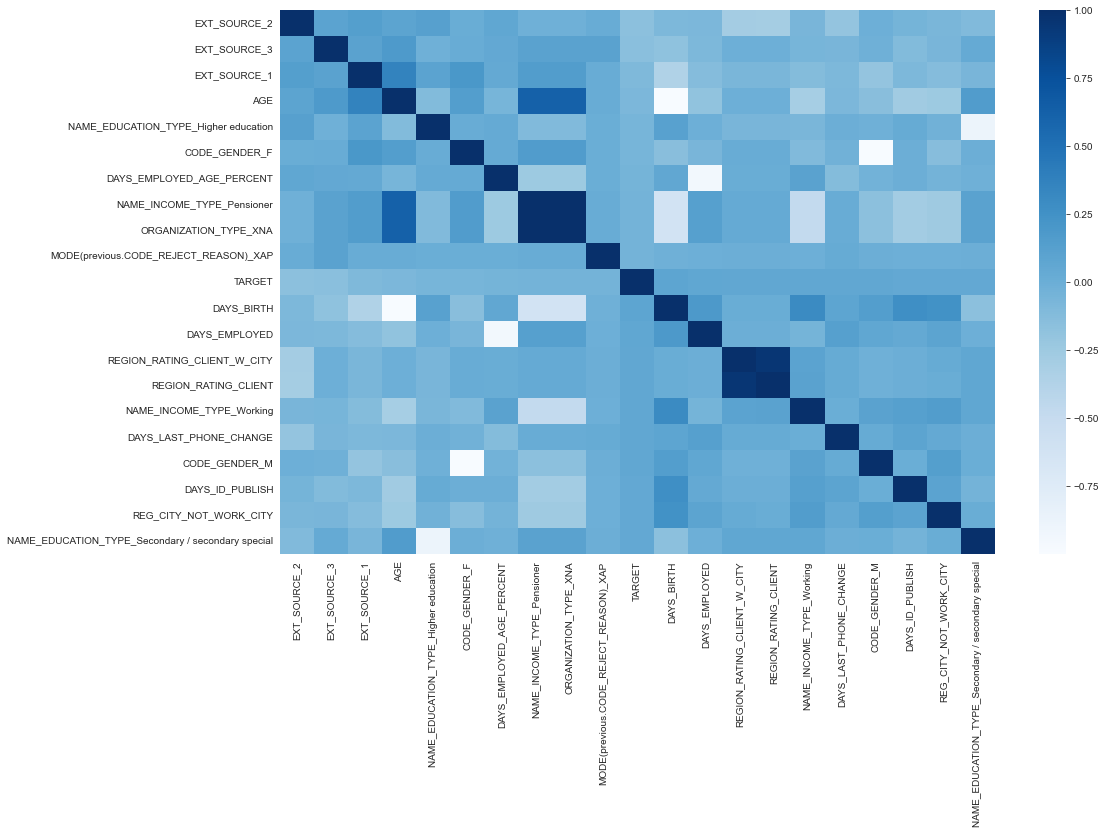

In [ ]:
#Membuat dataframe baru yang hanya berisi dataframe dengan korelasi positif dan negatif tertinggi
df_top_corr = df_corr[top_corr]

# Heatmap

plt.figure(figsize = (16,10))
sns.heatmap(df_top_corr.corr(),cmap="Blues")

### Analisis Deskriptif dan Diagnosis

In [ ]:
#Membuat fungsi untuk memplot grafik kategorikal

def plot_stats(feature, label_rotation=False, horizontal_layout=True):
    #Menghitung persentase target=1 per nilai kategorikal
    cat_perc = df2[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)

    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s1 = sns.countplot(data=df2, x=feature, ax=ax1, order=df2[feature].value_counts().index)
    ax1.set_ylabel('Jumlah kontrak', fontsize=10)
    s2 = sns.barplot(data=cat_perc, x=feature, y='TARGET', ax=ax2, order=cat_perc[feature])
    if(label_rotation):
        s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
        s2.set_xticklabels(s2.get_xticklabels(),rotation=90)
    ax2.set_ylabel("Persentase target dengan nilai 1 (%)", fontsize=10)
    fig.tight_layout
    plt.show()

In [ ]:
# Membuat fungsi untuk memplot grafik distribusi data numerikal dengan satu fitur
def plot_distribution(feature, color):
    plt.figure(figsize=(10,6))
    plt.title("Distribution dari %s" % feature)
    sns.kdeplot(df2[feature].dropna(),color=color, kde=True,bins=100)
    plt.ticklabel_format(style='plain')
    plt.show()

In [ ]:
# Membuat fungsi untuk memplot grafik distribusi data numerikal dengan satu fitur, dengan target 1/0
def plot_distribution_target(feature):
    t1 = df2.loc[df2['TARGET'] != 0]
    t0 = df2.loc[df2['TARGET'] == 0]

    plt.figure(figsize=(10,6))
    plt.title("Distribusi dari %s" % feature)
    sns.kdeplot(t1[feature], bw=0.5, label='TARGET = 1')
    plt.legend()
    sns.kdeplot(t0[feature], bw=0.5, label='TARGET = 0')
    plt.legend()
    plt.ylabel('Density', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    plt.ticklabel_format(style='plain')
    plt.show()

In [ ]:
# Membuat fungsi untuk memplot grafik distribusi dengan beberapa fitur, dengan target 1/0
def plot_distribution_comp(var,nrow=2):
    i = 0
    t1 = df2.loc[df2['TARGET'] != 0]
    t0 = df2.loc[df2['TARGET'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(12,6*nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow,2,i)
        sns.kdeplot(t1[feature], bw=0.5, label='TARGET = 1')
        plt.legend()
        sns.kdeplot(t0[feature], bw=0.5, label='TARGET = 0')
        plt.legend()
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
    plt.ticklabel_format(style='plain')
    plt.show();

In [ ]:
categorical_list = []
numerical_list = []
for i in df2.columns.tolist():
    if df2[i].dtype=='category':
        categorical_list.append(i)
    else:
        numerical_list.append(i)
print('Number of categorical features:', str(len(categorical_list)))
print('Number of numerical features:', str(len(numerical_list)))

Number of categorical features: 9
Number of numerical features: 38


#### Plotting Kolom Kategori

In [ ]:
categorical_list

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_HOUSING_TYPE',
 'ORGANIZATION_TYPE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'MODE(previous.CODE_REJECT_REASON)']

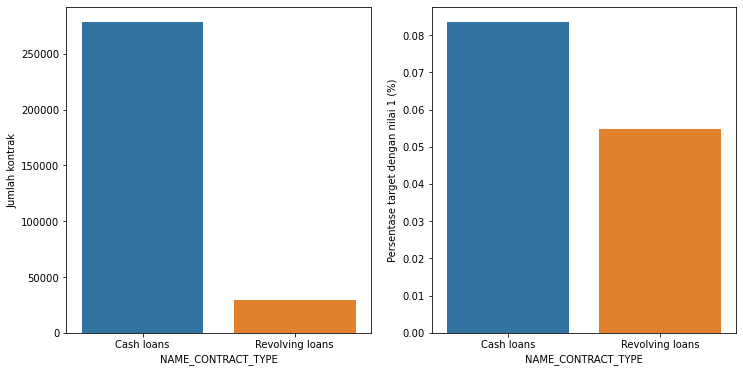

In [ ]:
# Tipe Kontrak

plot_stats('NAME_CONTRACT_TYPE')

Klien bertipe kontrak **Revolving loans** mempunyai jumlah yang sangat sedikit dibandingkan klien bertipe kontrak **Cash loans**. Akan tetapi, walaupun mempunyai jumlah kontrak yang sedikit, persentase klien **gagal bayar** tidak berbeda jauh jika dibandingkan dengan kontrak **Cash loans**

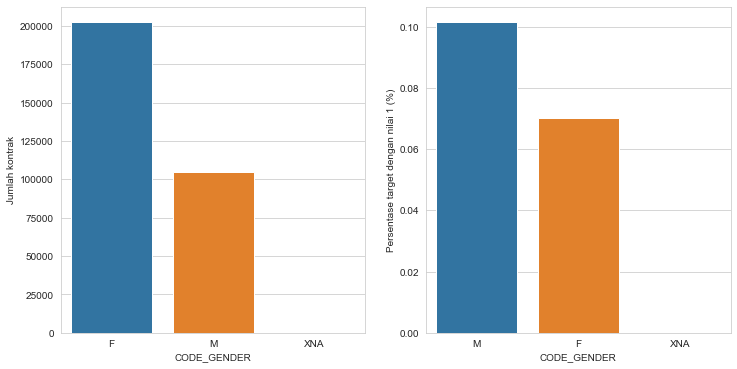

In [ ]:
# Code gender

plot_stats('CODE_GENDER')

Jumlah kontrak yang dilakukan klien wanita hampir **dua kali lipat** lebih banyak dibandingkan kontrak yang dilakukan klien pria. **Menariknya**, klien pria mempunyai persentase **gagal bayar** lebih tinggi dibandingkan klien wanita melihat frekuensi klien pria yang 50% lebih sedikit dibanding wanita.

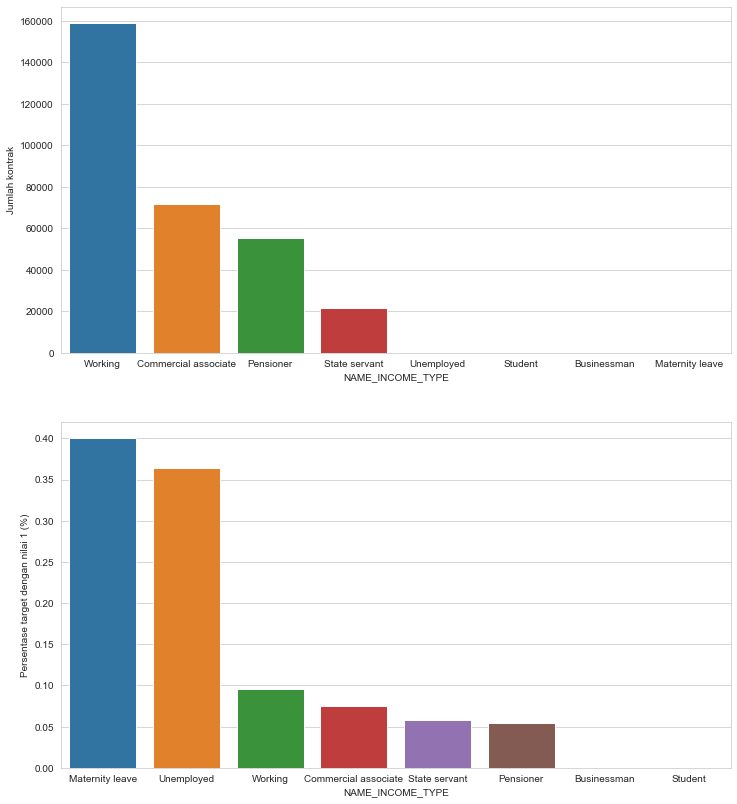

In [ ]:
# Tipe kontrak

plot_stats('NAME_INCOME_TYPE', False, False)

In [ ]:
#Melihat jumlah klien dengan tipe pekerjaan yang tidak terlihat melalui grafik

df2['NAME_INCOME_TYPE'].value_counts()

Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64

Sebagian besar klien yang mengajukan kontrak mempunyai jenis pekerjaan **Working, Commercial Associate, Pensioner, dan State Servant**.

Jika kita melihat pada grafik persentase gagal bayar, klien yang mempunyai tipe pekerjaan **Maternity leave dan Unemployed** mempunyai tingkat gagal bayar yang sangat tinggi (diatas 35%). Sedangkan untuk jenis pekerjaan yang lain mempunyai tingkat gagal bayar dibawah 10%. **Selain itu**, jenis pekerjaan **State servant** mempunyai tingkat gagal bayar yang lebih tinggi dibandingkan **Pensioner** walaupun mempunyai jumlah klien yang mengajukan kontrak 60% lebih sedikit dibandingkan Pensioner.

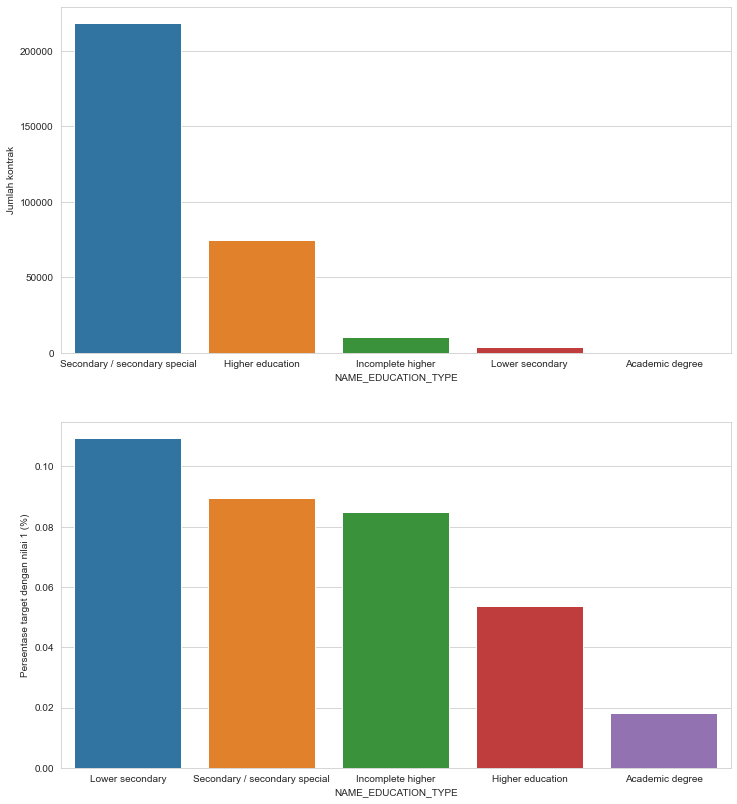

In [ ]:
# Tipe pendidikan
plot_stats('NAME_EDUCATION_TYPE', False, False)

Tipe edukasi klien yang paling banyak dalam mengajukan kontrak adalah: **Secondary special dan Higher education**. Walaupun begitu, klien yang mempunyai tingkat gagal bayar yang paling tinggi adalah klien dengan tipe edukasi **Lower secondary**. Selain itu, walaupun tipe pendidikan **Incomplete higher** mempunyai jumlah kontrak yang jauh lebih sedikit dibandingkan tipe **Higher education**, namun **Incomplete higher** mempunyai tingkat gagal bayar lebih tinggi dibandingkan **Higher education**.

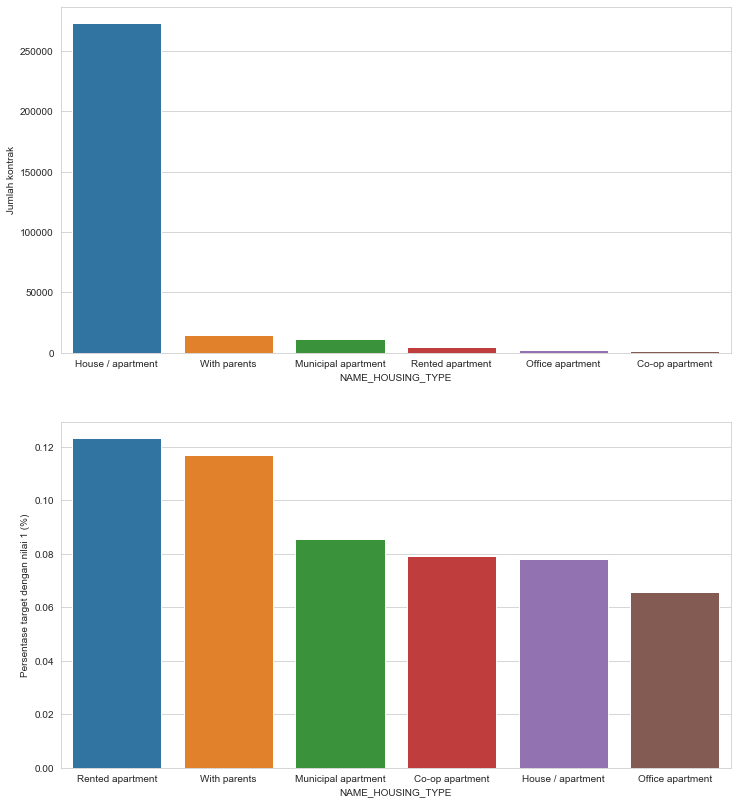

In [ ]:
# Tipe rumah
plot_stats('NAME_HOUSING_TYPE', False, False)

Tipe rumah klien yang mengajukan kontrak didominasi oleh tipe rumah **House/apartment**. Walaupun begitu, klien dengan tipe rumah **Rented apartment dan With parents** mempunyai persentase gagal bayar paling tinggi (>10%), sedangkan klien dengan tipe rumah **House/apartment** mempunyai persentase gagal bayar yang tergolong rendah (<8%).

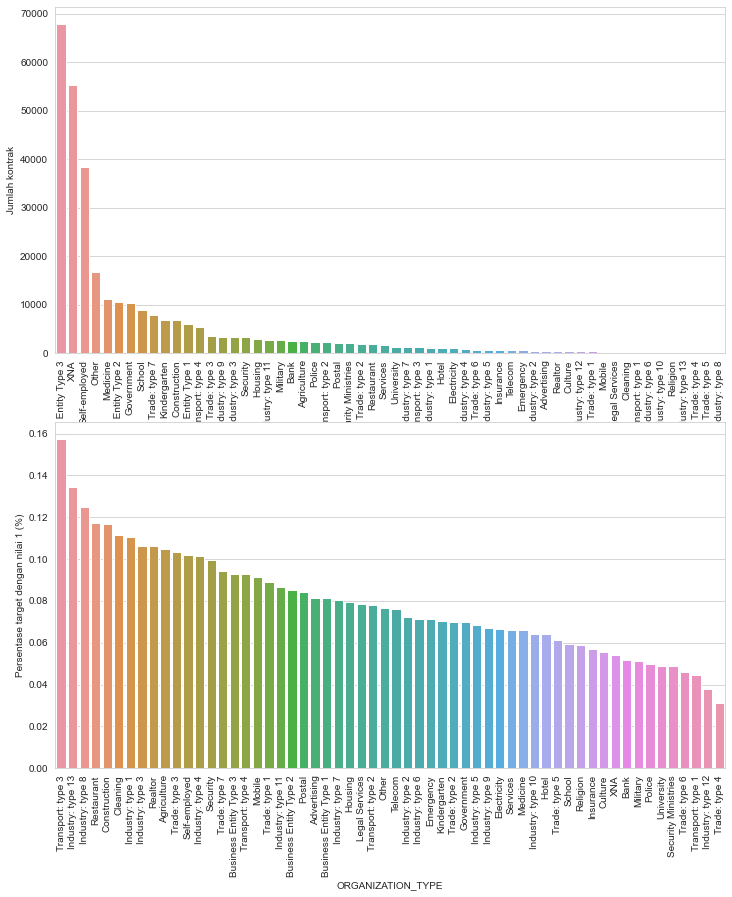

In [ ]:
# Tipe organisasi

plot_stats('ORGANIZATION_TYPE', True, False)

Kebanyakan klien yang mengajukan kontrak mempunyai tipe organisasi **Business Entity: Type 3, XNA, dan Self-employed**. Sedangkan tipe organisasi yang mempunyai klien dengan tingkat gagal bayar paling tinggi adalah **Transport: type 3, Industry: type 13, dan Industry: type 8**. Menariknya, klien dengan tipe organisasi **XNA** mempunyai tingkat gagal bayar yang tergolong rendah jika dibandingkan dengan tipe organisasi lainnya.

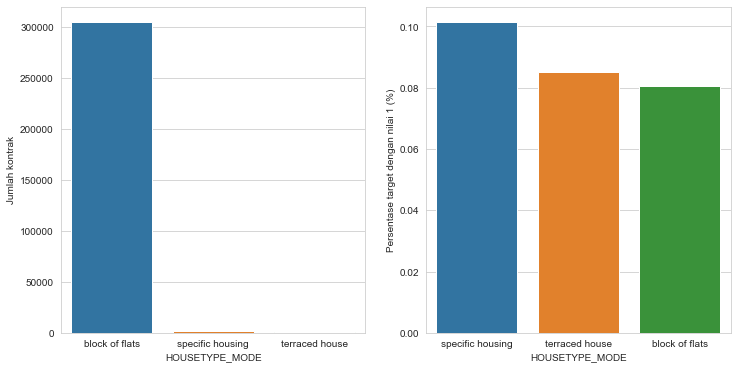

In [ ]:
## Mode Jenis Rumah

plot_stats('HOUSETYPE_MODE')

Klien dengan mode jenis rumah yang paling banyak mengajukan kontrak adalah **block of flats**. Namun, jika kita melihat dari tingkat persentase gagal bayar, klien dengan mode jenis rumah **block of flats** merupakan klien yang mempunyai tingkat persentase gagal bayar paling rendah.

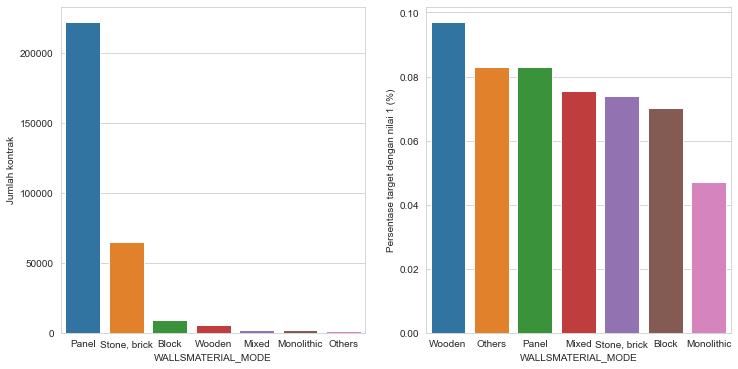

In [ ]:
# Mode Walls Material


plot_stats('WALLSMATERIAL_MODE')

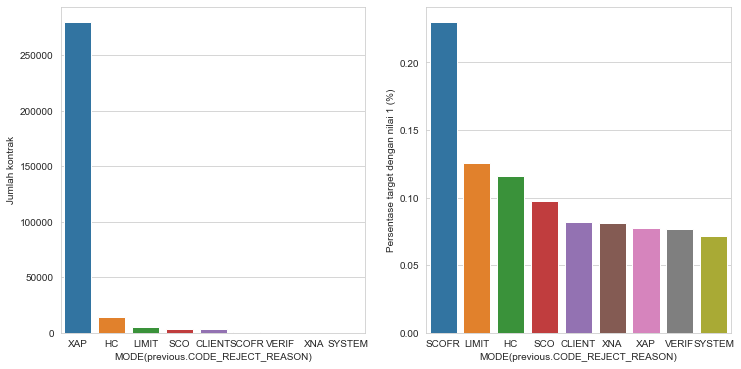

In [ ]:
# Mode dari alasan ditolaknya aplikasi pada previous_application.csv

plot_stats('MODE(previous.CODE_REJECT_REASON)')

Kebanyakan penolakan kontrak klien pada aplikasi sebelumnya adalah karena alasan **XAP**. Walaupun begitu, pada kontrak saat ini, klien dengan persentase gagal bayar paling tinggi adalah klien dengan alasan penolakan **SCOFR** pada aplikasi sebelumnya.

In [ ]:
top_corr

['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'EXT_SOURCE_1',
 'AGE',
 'NAME_EDUCATION_TYPE_Higher education',
 'CODE_GENDER_F',
 'DAYS_EMPLOYED_AGE_PERCENT',
 'NAME_INCOME_TYPE_Pensioner',
 'ORGANIZATION_TYPE_XNA',
 'MODE(previous.CODE_REJECT_REASON)_XAP',
 'TARGET',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'REGION_RATING_CLIENT_W_CITY',
 'REGION_RATING_CLIENT',
 'NAME_INCOME_TYPE_Working',
 'DAYS_LAST_PHONE_CHANGE',
 'CODE_GENDER_M',
 'DAYS_ID_PUBLISH',
 'REG_CITY_NOT_WORK_CITY',
 'NAME_EDUCATION_TYPE_Secondary / secondary special']

<Figure size 432x288 with 0 Axes>

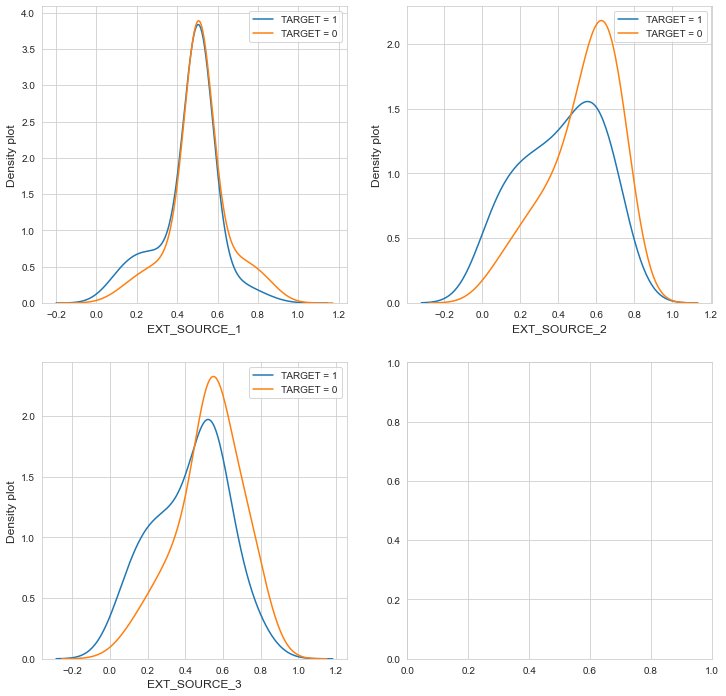

In [ ]:
var = ['EXT_SOURCE_1','EXT_SOURCE_2', 'EXT_SOURCE_3']
plot_distribution_comp(var,nrow=2)

Jika dilihat pada grafik EXT_SOURCE_2 dan EXT_SOURCE_3, kita dapat melihat suatu hubungan antara EXT_SOURCE_2 dan EXT_SOURCE_3 dengan target. EXT_SOURCE_1 mengikuti normal distribution.

<Figure size 432x288 with 0 Axes>

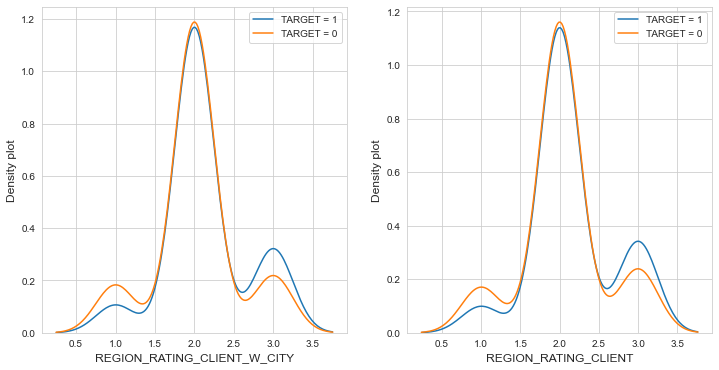

In [ ]:
var = ['REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT']
plot_distribution_comp(var,nrow=1)

REGION_RATING_CLIENT_W_CITY dan REGION_RATING_CLIENT mempunyai jumlah klien gagal bayar terbanyak pada rating 2

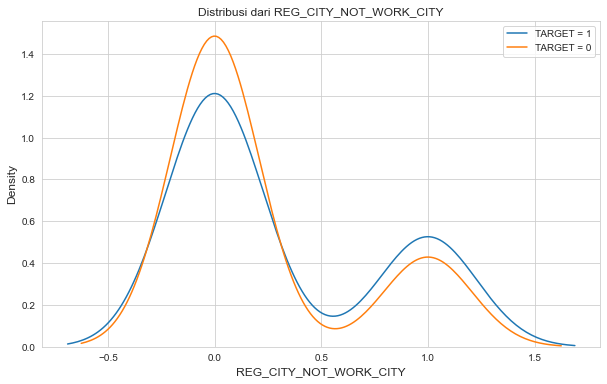

In [ ]:
plot_distribution_target('REG_CITY_NOT_WORK_CITY')

Pada grafik REG_CITY_NOT_WORK_CITY, klien gagal bayar terbanyak terdapat pada REG_CITY_NOT_WORK_CITY 0.0, kemudian menurun pada 0.5, dan naik kembali pada 1.0

<Figure size 432x288 with 0 Axes>

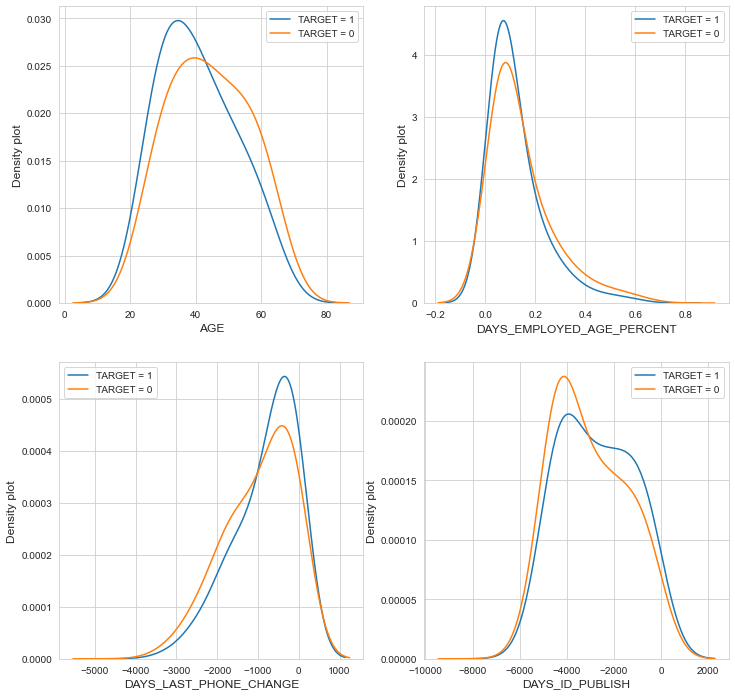

In [ ]:
var = ['AGE', 'DAYS_EMPLOYED_AGE_PERCENT', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH']
plot_distribution_comp(var,nrow=2)

Pada grafik density AGE dan DAYS EMPLOYED AGE PERCENT, dapat dilihat bahwa mayoritas klien yang gagal bayar berada pada rentang umur 30-40 dengan pengalaman atau jam terbang kerja berkisar 10% dari umur klien. **Semakin bertambah umur dan jam terbang bekerja, maka klien yang gagal bayar semakin sedikit**. Pada grafik DAYS LAST PHONE CHANGE, klien gagal bayar paling banyak berada pada sekitar -500 DAYS LAST PHONE CHANGE. Pada grafik DAYS ID PUBLISH, klien gagal bayar paling banyak berada pada sekitar -4000 DAYS ID PUBLISH.

#### Pembuatan CSV baru untuk dashboard

In [ ]:
top_corr

['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'EXT_SOURCE_1',
 'AGE',
 'NAME_EDUCATION_TYPE_Higher education',
 'CODE_GENDER_F',
 'DAYS_EMPLOYED_AGE_PERCENT',
 'NAME_INCOME_TYPE_Pensioner',
 'ORGANIZATION_TYPE_XNA',
 'MODE(previous.CODE_REJECT_REASON)_XAP',
 'TARGET',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'REGION_RATING_CLIENT_W_CITY',
 'REGION_RATING_CLIENT',
 'NAME_INCOME_TYPE_Working',
 'DAYS_LAST_PHONE_CHANGE',
 'CODE_GENDER_M',
 'DAYS_ID_PUBLISH',
 'REG_CITY_NOT_WORK_CITY',
 'NAME_EDUCATION_TYPE_Secondary / secondary special']

In [ ]:
top_corr_col = ['EXT_SOURCE_2','EXT_SOURCE_3','EXT_SOURCE_1','AGE','NAME_EDUCATION_TYPE','CODE_GENDER',
               'DAYS_EMPLOYED_AGE_PERCENT','NAME_INCOME_TYPE','ORGANIZATION_TYPE','MODE(previous.CODE_REJECT_REASON)',
                'TARGET','DAYS_EMPLOYED','REGION_RATING_CLIENT_W_CITY','REGION_RATING_CLIENT','DAYS_LAST_PHONE_CHANGE',
                'DAYS_ID_PUBLISH','REG_CITY_NOT_WORK_CITY']
df_dashboard = df2[top_corr_col]

In [ ]:
df_dashboard.to_csv('dashboard.csv')

## Solusi dan Rekomendasi

* Pada pemodelan Machine Learning, algoritma yang direkomendasikan dalam memprediksi suatu klien gagal bayar atau tidak adalah algoritma **Xtreme Gradient Boost (XGB) dan Light Gradient Boosting Machine (LGBM)**
* Korelasi paling tinggi pada dataset Home Credit adalah **EXT_SOURCE_2** dan **EXT_SOURCE_3** dengan korelasi negatif yang mencapai < -0.15. **Semakin tinggi nilai EXT_SOURCE_2 dan EXT_SOURCE_3, maka semakin rendah kemungkinan gagal bayar**. Maka dari itu, disarankan untuk mengadakan kampanye pada klien yang mempunyai nilai EXT_SOURCE_2 dan EXT_SOURCE_3 yang tinggi untuk mengurangi **Non Performing Loan (NPL)**.
* Walaupun jumlah klien pria yang mengajukan kontrak 50% lebih sedikit dibandingkan wanita, namun klien pria mempunyai presentase gagal bayar yang lebih tinggi. **Maka dari itu, disarankan untuk memfokuskan kampanye atau penawaran pada wanita.**
* **Hindari/kurangi klien dengan background income Unemployed dan Maternity Leave**.
* ORGANIZATION_TYPE_XNA dan NAME_INCOME_TYPE_Pensioner mempunyai suatu hubungan satu sama lain. Dapat dilihat dari korelasinya pada setiap kolom yang hampir sama. Selain itu, ORGANIZATION_TYPE_XNA dan NAME_INCOME_TYPE_Pensioner juga mempunyai korelasi negatif dengan TARGET. **Maka dari itu, disarankan untuk memfokuskan kampanye penawaran pada klien dengan tipe organisasi XNA dan income Pensioner.**
* Umur mempunyai korelasi negatif dengan TARGET. Klien dengan umur yang lebih muda mempunyai persentase gagal bayar yang lebih tinggi dibandingkan klien yang lebih tua. **Maka dari itu, disarankan untuk memfokuskan kampanye penawaran pada klien dengan umur diatas 40.**
* **Hindari/kurangi klien dengan background pendidikan Lower secondary atau secondary.** Selain itu, klien dengan background pendidikan Higher education juga berkorelasi negatif dengan TARGET. **Disarankan untuk memfokuskan kampanye penawaran pada klien dengan background pendidikan Higher education.**
* **Hindari/kurangi klien dengan jenis tempat tinggal atau with parents (dengan orang tua) dan fokuskan kampanye penawaran pada klien dengan jenis tempat tinggal rumah/apartemen.**
* **Hindari/kurangi klien dengan tipe rumah specific housing dan terrace house.**
* **Hindari/kurangi klien dengan tipe WALLSMATERIAL wOODEN.**
* **Hindari/kurangi klien jika pada aplikasi sebelumnya sudah tertolak dengan alasan SCOFR. Fokuskan kampanye pada klien yang aplikasi sebelumnya tertolak dengan alasan XAP.**